In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as sp

import joblib

from numpy.typing import ArrayLike

# ML lybraries
import xgboost as xgb
import optuna as opt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, precision_recall_curve, roc_curve, auc, ndcg_score
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.combine import SMOTETomek
from insurance_classifier.dataset import DataPreprocessor

# 0.0 Loading data

In [2]:
train = pd.read_csv('../data/processed/train.csv')

X = train.drop(['response'], axis=1)
y = train['response'].copy()


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 0.1 Helper Functions

In [41]:
def check_imbalance(df: pd.DataFrame)-> pd.DataFrame: 
    total = df.shape[0]
    no_count = df['response'].value_counts().iloc[0]
    yes_count = df['response'].value_counts().iloc[1]

    def highlight(val):
        return 'background-color: red; color: white; font-weight: bold;' if val < 20 else ''

    no_percentage = (no_count/total) * 100
    yes_percentage = 100 - no_percentage

    df_dist = pd.DataFrame({'no_count': no_count,
                            'yes_count': yes_count,
                            'no_percentage': no_percentage,
                            'yes_percentage': yes_percentage
                }, index=[0]).style.map(highlight, subset=['no_percentage','yes_percentage'])

    return df_dist 

def precision_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]   
    
    return np.mean(y_true.iloc[idx])

def recall_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]  

    return np.sum(y_true.iloc[idx]) / np.sum(y_true) if np.sum(y_true) > 0 else 0

def f_score_at_k(y_true, y_proba, *, k):   
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k] 

    precision = np.mean(y_true.iloc[idx])
    recall = np.sum(y_true.iloc[idx]) / np.sum(y_true)

    return  2 * ((precision * recall)/(precision + recall)) if (precision + recall) > 0 else 0


def cross_validation_at_k(model:BaseEstimator, X:pd.DataFrame, y:ArrayLike|None, return_dict:bool=False, verbose:int=0, *, cv:int=5, k:int)-> pd.DataFrame | np.ndarray: 
    """
    Perform cross-validation using @k metrics (precision@k, recall@k, and F1-score@k) as the scoring method.

    Parameters
    ----------
    model : instance of estimator, needs to inherit from sklearn's BaseEstimator.
        Estimator object to be evaluated.

    X : dataframe of shape (n_samples, n_features). 
        Training data.

    y : array-like of shape (n_samples,)
        Target values.

    return_dict : boolean, default=False
        If True, returns the raw cross-validation results dictionary.

    verbose : int, default=0
        Verbosity level for cross-validation process.

    cv : int, default=5
        Number of cross-validation folds. If use int, specify number of folds in a Stratified KFold. 

    k : int
        The top k values for metrics @k.

    Returns
    ---------
    pd.Dataframe | dict : pandas dataframe or dict
        Dataframe or dict with precision@k, recall@k, f1-score@k, calculated for each cv fold.
    
    See Also
    --------
    sklearn.model_selection.cross_validate : Perform cross-validation.
    make_scorer : Convert a metric function into a scorer object.
    """
    precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=k)
    recall_at_k_scorer = make_scorer(recall_at_k, response_method='predict_proba', k=k)
    f1_at_k_scorer = make_scorer(f_score_at_k, response_method='predict_proba', k=k)  

    model_results = cross_validate(model, X, y, cv=cv, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer},verbose=verbose)

    if return_dict:
        return model_results

    at_k_metrics = pd.DataFrame(model_results)
    at_k_metrics.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
    at_k_metrics.drop(columns='score_time', inplace=True)
    at_k_metrics = at_k_metrics[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
    at_k_metrics = at_k_metrics.sort_values(by='precision@k', ascending=False)

    
    return at_k_metrics

def cross_val_summary(results_dict:dict) -> pd.DataFrame:
    """
    Summarizes the results of cross-validation for multiple models.

    Parameters
    ----------
    results_dict : dict of shape {str: pd.DataFrame}
        A dictionary where keys are model names and values are dataframes containing cross-validation results.
    
    Returns
    -------
    pd.DataFrame
        A dataframe summarizing the mean precision@k, recall@k, f1-score@ and fit time for each model.
    """ 
    rows = []  

    for name, r in results_dict.items():
        rows.append({
            'Model Name': name,
            'precision@k_mean': np.round(np.mean(r['precision@k']), 5),
            'precision@k_std': np.std(r['precision@k']),
            'recall@k_mean': np.round(np.mean(r['recall@k']), 5),
            'recall@k_std': np.std(r['recall@k']),
            'f1-score@k_mean': np.round(np.mean(r['f1-score@k']), 5),
            'f1-score@k_std': np.std(r['f1-score@k']),
            'fit_time_mean': np.round(np.mean(r['fit_time']), 5),
        })

    df = pd.DataFrame(rows).sort_values(by='precision@k_mean', ascending=False)

    return df

def cumulative_gain(y_true, y_scores):
    order = np.argsort(y_scores)[::-1]
    y_sorted = y_true[order]

    cumulative = np.cumsum(y_sorted)
    total_pos = y_true.sum()

    gain = cumulative / total_pos
    perc = np.arange(1, len(y_true)+1) / len(y_true)

    return perc, gain

def lift_curve(y_true, y_score):
    order = np.argsort(-y_score)
    y_sorted = y_true[order]

    cum_pos = np.cumsum(y_sorted)

    total_pos = cum_pos[-1]
    n = len(y_true)

    x = np.arange(1, n+1) / n

    gain = cum_pos / total_pos

    lift = gain / x

    return x, lift


---

---

# 1.0 Linear Models (baseline)

### 1.1 SGD Classifier with Linear SVM (Loss function = hinge)

In [18]:
# Model initialization
sgd_lin = SGDClassifier(loss='hinge')

# Predict probabilities
clf = CalibratedClassifierCV(sgd_lin)

# Train
clf.fit(X_train, y_train)

# Predict
y_hat_lin = clf.predict_proba(X_test)[:,1]

### 1.2 SGD Classifier with Logistic Regression (Loss function = log-loss)

In [68]:
# Model initialization
sgd_log = SGDClassifier(loss='log_loss')

# Train
sgd_log.fit(X_train, y_train)

# Predict
y_hat_log = sgd_log.predict_proba(X_test)

<b>Baseline Performance</b>:

In [ ]:
# Linear SVM
precision_lin = precision_at_k(y_true=y_test, y_proba=y_hat_lin, k=20000)
recall_lin = recall_at_k(y_true=y_test, y_proba=y_hat_lin, k=20000)

# Log-loss
precision_log = precision_at_k(y_true=y_test, y_proba=y_hat_log, k=20000)
recall_log = recall_at_k(y_true=y_test, y_proba=y_hat_log, k=20000)

# Dataframe
results = pd.DataFrame({'Model': ['Linear SVM', 'logistic regression'],
                        '@k': [20000, 20000],
                        'Precision@k': [precision_lin, precision_log],
                        'Recall@k': [recall_lin, recall_log]})
results

,Model,@k,Precision@k,Recall@k
0,Linear SVM,20000,0.30280,0.652586
1,logistic regression,20000,0.31235,0.673168


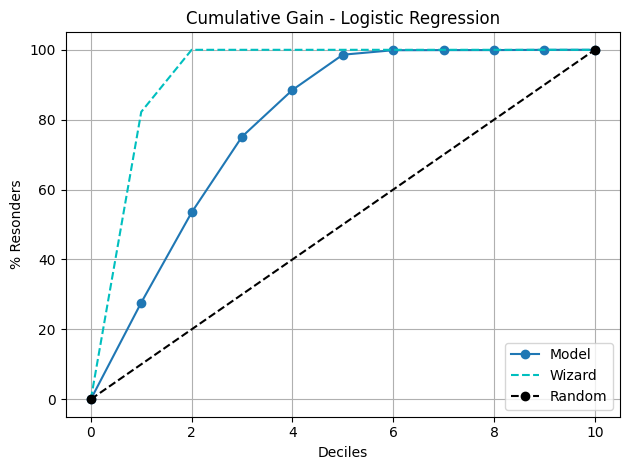

In [ ]:
sp.kds.plot_cumulative_gain(y_test, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

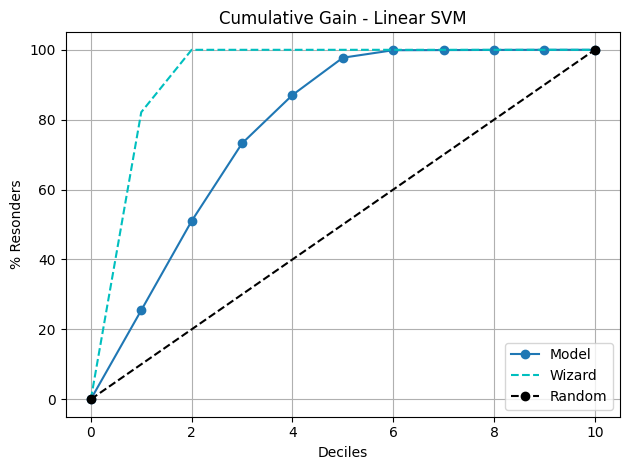

In [ ]:
sp.kds.plot_cumulative_gain(y_test, y_hat_lin[:,1], title='Cumulative Gain - Linear SVM');

# 2.0 Non-linear Models (baseline)

## 2.1. K Neighbors Classifier

In [ ]:
# model initialization
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X, y)

# Predict
knn_proba = knn.predict_proba(X_test)

<b>Baseline Performance</b>:

In [ ]:
# KNN
precision_knn = precision_at_k(y_true=y, y_proba=knn_proba, k=20000)
recall_knn = recall_at_k(y_true=y, y_proba=knn_proba, k=20000)

# Dataframe
results_knn = pd.DataFrame({'Model': ['KNN'],
                        '@k': 20000,
                        'Precision@k': precision_knn,
                        'Recall@k': recall_knn})
results_knn

,Model,@k,Precision@k,Recall@k
0,KNN,20000,0.28305,0.610745


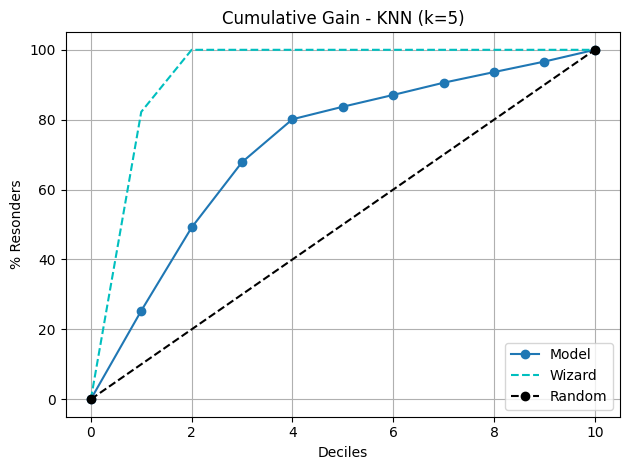

In [ ]:
sp.kds.plot_cumulative_gain(y_test, knn_proba[:,1], title='Cumulative Gain - KNN (k=5)');

## 2.3 XGB Classifier

In [7]:
# Model initialization
xgb_class = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)

# Fit
xgb_class.fit(X_train, y_train)

# Predict
y_hat_xgb = xgb_class.predict_proba(X_test)

In [8]:
precision_xgb = precision_at_k(y_true=y, y_proba=y_hat_xgb, k=20000)
recall_xgb = recall_at_k(y_true=y, y_proba=y_hat_xgb, k=20000)

# Dataframe
results_xgb = pd.DataFrame({'Model': ['XGB'],
                        '@k': 20000,
                        'Precision@k': precision_xgb,
                        'Recall@k': recall_xgb})
results_xgb

,Model,@k,Precision@k,Recall@k
0,XGB,20000,0.12215,0.052301


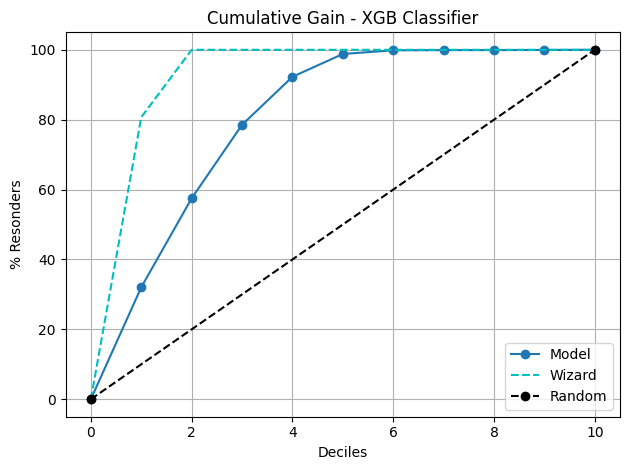

In [14]:
sp.kds.plot_cumulative_gain(y_test, y_hat_xgb[:,1], title='Cumulative Gain - XGB Classifier');

## 2.4 Extra Trees Classifier

In [9]:
# Model initialization
ex_trees = ExtraTreesClassifier(n_jobs=-1)

# Fit
ex_trees.fit(X_train, y_train)

# Predict
y_hat_extrees = ex_trees.predict_proba(X_test)

<b>Baseline Performance</b>:

In [10]:
precision_extrees = precision_at_k(y_true=y, y_proba=y_hat_extrees, k=20000)
recall_extrees = recall_at_k(y_true=y, y_proba=y_hat_extrees, k=20000)

# Dataframe
results_extrees = pd.DataFrame({'Model': ['ExtraTrees'],
                        '@k': 20000,
                        'Precision@k': precision_extrees,
                        'Recall@k': recall_extrees})
results_extrees

,Model,@k,Precision@k,Recall@k
0,ExtraTrees,20000,0.1221,0.05228


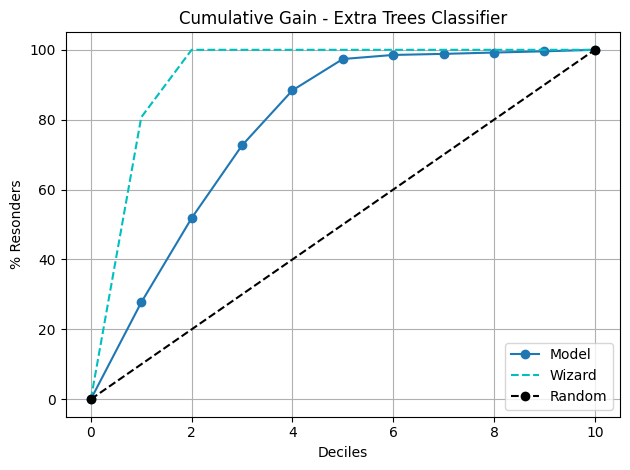

In [15]:
sp.kds.plot_cumulative_gain(y_test, y_hat_extrees[:,1], title='Cumulative Gain - Extra Trees Classifier');

---

---

# 3.0 Cross validation

## 3.1 SGD Classifier: Linear SVM  

In [47]:
# Model definition
sgd_lin = SGDClassifier(loss='hinge')

# Converting predictions into probabilities
sgd_lin_cal = CalibratedClassifierCV(sgd_lin)

In [43]:
# Cross validated performance
sgd_lin_results = cross_validation_at_k(sgd_lin_cal, X_train, y_train, cv=5, k=20000)
sgd_lin_results

,precision@k,recall@k,f1-score@k,fit_time
4,0.29430,0.788585,0.428634,2.376976
0,0.28995,0.776929,0.422298,2.779930
2,0.28890,0.774116,0.420769,2.182502
1,0.28750,0.770364,0.418730,2.100841
3,0.27985,0.749866,0.407588,2.290913


## 3.2 SGD Classifier: Logistic regression 

In [48]:
# Model definition
sgd_log = SGDClassifier(loss='log_loss')

# Cross validated performance
sgd_log_results = cross_validation_at_k(sgd_log, X_train, y_train, cv=5, k=20000)
sgd_log_results

,precision@k,recall@k,f1-score@k,fit_time
0,0.29765,0.796495,0.433355,0.689901
1,0.29600,0.792079,0.430953,0.427733
2,0.29595,0.792051,0.430896,14.469657
4,0.29490,0.789136,0.429351,0.423915
3,0.29450,0.788171,0.428785,-13.640623


## 3.3 K-Neighbors Classifier (K=5)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


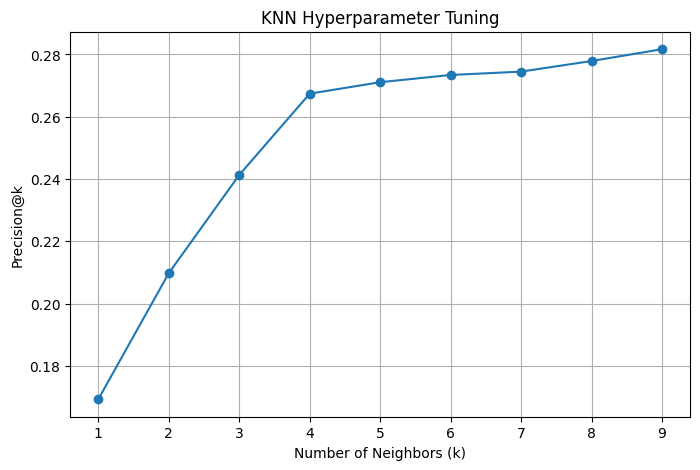

In [8]:
k_values = range(1, 10)
scores = []
precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=20000)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring=precision_at_k_scorer, verbose=1)
    scores.append(cv_score.mean())

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Precision@k")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.show()

In [49]:
# Model definition
knn = KNeighborsClassifier(n_neighbors=10)

# Cross validated performance
knn_results = cross_validation_at_k(knn, X_train, y_train, cv=5, k=20000)
knn_results

,precision@k,recall@k,f1-score@k,fit_time
2,0.28545,0.763950,0.415608,0.563602
4,0.28515,0.763045,0.415156,0.521305
0,0.28500,0.762644,0.414938,0.549517
1,0.28375,0.759299,0.413118,-13.577700
3,0.28345,0.758598,0.412696,0.470456


## 3.4 XGB Classifier

In [50]:
# Model definition
xgb_class = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)

# Cross validated performance
xgb_results = cross_validation_at_k(xgb_class, X_train, y_train, cv=5, k=20000)
xgb_results

,precision@k,recall@k,f1-score@k,fit_time
0,0.31235,0.835831,0.454757,0.696879
3,0.30955,0.828449,0.450697,14.538364
4,0.30890,0.826599,0.449734,-13.471205
2,0.30805,0.824435,0.448513,0.640054
1,0.30750,0.822853,0.447696,0.852321


## 3.5. Extra Trees Classifier

In [51]:
# Model definition
extrees = ExtraTreesClassifier(n_jobs=-1)

# Cross validated performance
extrees_results = cross_validation_at_k(extrees, X_train, y_train, cv=5, k=20000)
extrees_results

,precision@k,recall@k,f1-score@k,fit_time
0,0.29145,0.779904,0.424328,7.146905
4,0.29125,0.779368,0.424037,6.351095
3,0.28895,0.773317,0.420704,7.004309
1,0.28865,0.772411,0.420252,6.045126
2,0.28795,0.770641,0.419248,6.742666


IOStream.flush timed out


## 3.6 Unbalanced data results

Results for the original dataset. In this section, the results are taken without any measures for the imbalance of the data. 

In [37]:
results = {'SGD Linear': sgd_lin_results,
           'SGD Logistic': sgd_log_results,
           'KNN': knn_results,
           'XGB Classifier': xgb_results,
           'Extra Trees Classifier': extrees_results
}

metrics_summary = cross_val_summary(results_dict=results)
metrics_summary

,Model Name,precision@k_mean,precision@k_std,recall@k_mean,recall@k_std,f1-score@k_mean,f1-score@k_std,fit_time_mean
3,XGB Classifier,0.30857,0.001956,0.82682,0.005240,0.44942,0.002848,0.77324
1,SGD Logistic,0.29539,0.001152,0.79151,0.003086,0.43022,0.001677,0.40459
4,Extra Trees Classifier,0.28733,0.002466,0.76991,0.006607,0.41848,0.003591,9.77706
0,SGD Linear,0.28689,0.005719,0.76873,0.015324,0.41784,0.008330,2.66272
2,KNN,0.27052,0.001789,0.72487,0.004794,0.39400,0.002606,0.58292


### Graphics:

In [47]:
sgd_lin_cal.fit(X_train, y_train)
sgd_log.fit(X_train, y_train)
xgb_class.fit(X_train, y_train)
extrees.fit(X_train, y_train)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [56]:
models_unbalanced = {'SGD Linear': sgd_lin_cal,
           'SGD Logistic': sgd_log,
           'XGB Classifier': xgb_class,
           'KNN': knn, 
           'Extra Trees Classifier': extrees
}

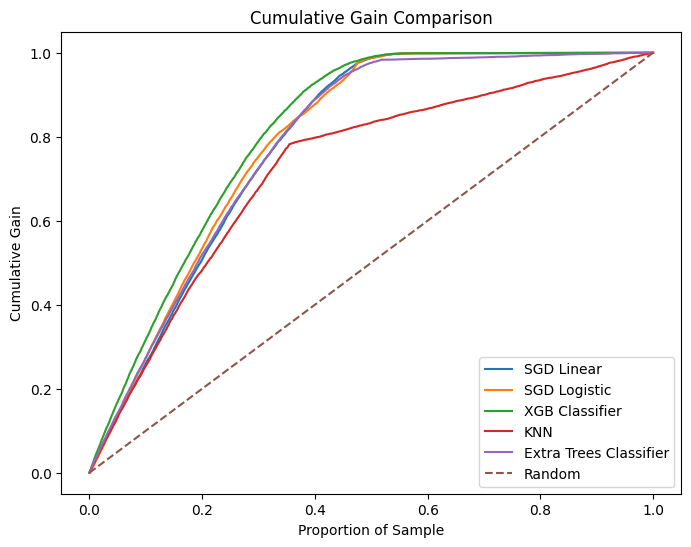

In [50]:
plt.figure(figsize=(8,6))

for name, model in models_unbalanced.items():
    y_scores = model.predict_proba(X_test)[:,1]
    x, y = cumulative_gain(y_test.values, y_scores)
    plt.plot(x, y, label=name)

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("Proportion of Sample")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.title("Cumulative Gain Comparison")
plt.show()

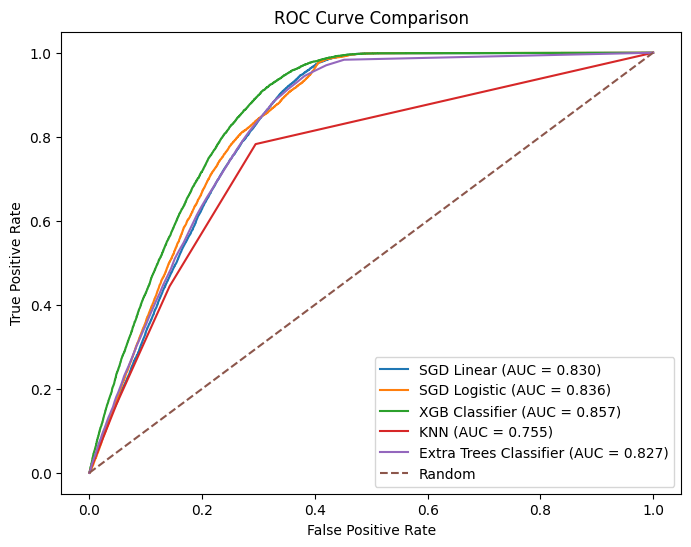

In [51]:
plt.figure(figsize=(8,6))

for name, model in models_unbalanced.items():
    y_scores = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

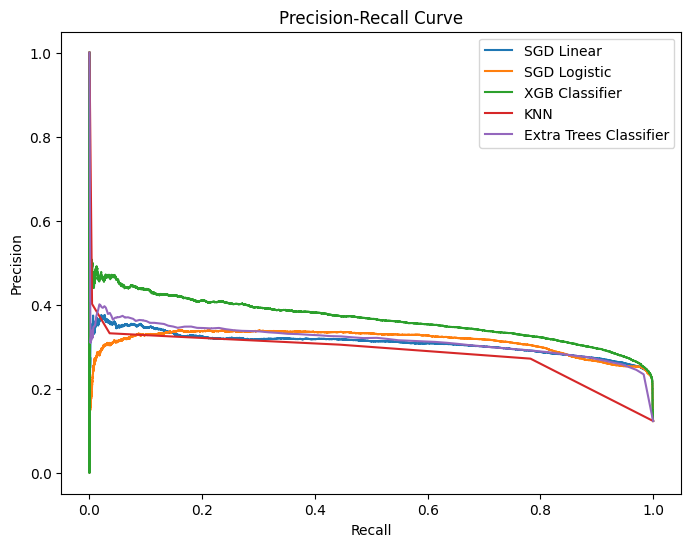

In [57]:
plt.figure(figsize=(8,6))

for name, model in models_unbalanced.items():
    y_scores = model.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## 3.7 Results for weighted models  

In this section we'll try to deal with the imbalance of the dataset through weight parameters in the models

### Performance on train data (Cross Validation at k):

In [15]:
sgd_lin_balanced = SGDClassifier(loss='hinge', class_weight='balanced')
w_sgd_lin = CalibratedClassifierCV(sgd_lin_balanced)

w_sgd_log = SGDClassifier(loss='log_loss', class_weight='balanced')
w_xgb = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, scale_pos_weight=7.3)
w_extrees = ExtraTreesClassifier(n_jobs=-1, class_weight='balanced')

In [53]:
# SGD Linear
w_sgd_results = cross_validation_at_k(w_sgd_lin, X_train, y_train, cv=5, k=20000)

# SGD Logistic
w_sgd_log_results = cross_validation_at_k(w_sgd_log, X_train, y_train, cv=5, k=20000)

#XGB Classifier
w_xgb_results = cross_validation_at_k(w_xgb, X_train, y_train, cv=5, k=20000)

# Extra Trees Classifier
w_extrees_results = cross_validation_at_k(w_extrees, X_train, y_train, cv=5, k=20000)

In [59]:
results = {'SGD Linear (Weighted)': w_sgd_results,
           'SGD Logistic (Weighted)': w_sgd_log_results,
           'XGB Classifier (Weighted)': w_xgb_results,
           'Extra Trees Classifier (Weighted)': w_extrees_results
}

metrics_summary = cross_val_summary(results_dict=results)
metrics_summary

,Model Name,precision@k_mean,recall@k_mean,f1-score@k_mean,fit_time_mean
2,XGB Classifier (Weighted),0.30877,0.82583,0.44948,0.62707
1,SGD Logistic (Weighted),0.29526,0.78970,0.42982,0.53323
0,SGD Linear (Weighted),0.29238,0.78199,0.42562,2.82745
3,Extra Trees Classifier (Weighted),0.28801,0.77031,0.41926,5.78267


### Graphics:

In [ ]:
w_sgd_lin.fit(X_train, y_train)
w_sgd_log.fit(X_train, y_train)
w_xgb.fit(X_train, y_train)
w_extrees.fit(X_train, y_train)

In [54]:
models_weighted = {'SGD Linear (Weighted)': w_sgd_lin,
           'SGD Logistic (Weighted)': w_sgd_log,
           'XGB Classifier (Weighted)': w_xgb,
           'Extra Trees Classifier (Weighted)': w_extrees
}

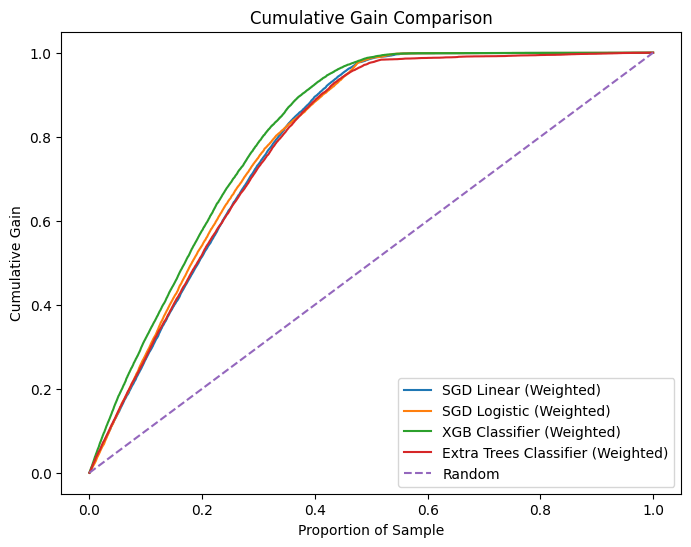

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models_weighted.items():
    y_scores = model.predict_proba(X_test)[:,1]
    x, y = cumulative_gain(y_test.values, y_scores)
    plt.plot(x, y, label=name)

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("Proportion of Sample")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.title("Cumulative Gain Comparison")
plt.show()

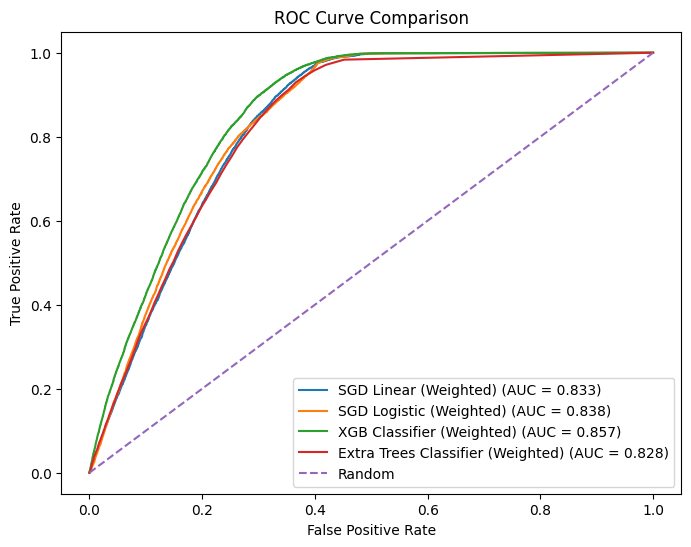

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models_weighted.items():
    y_scores = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

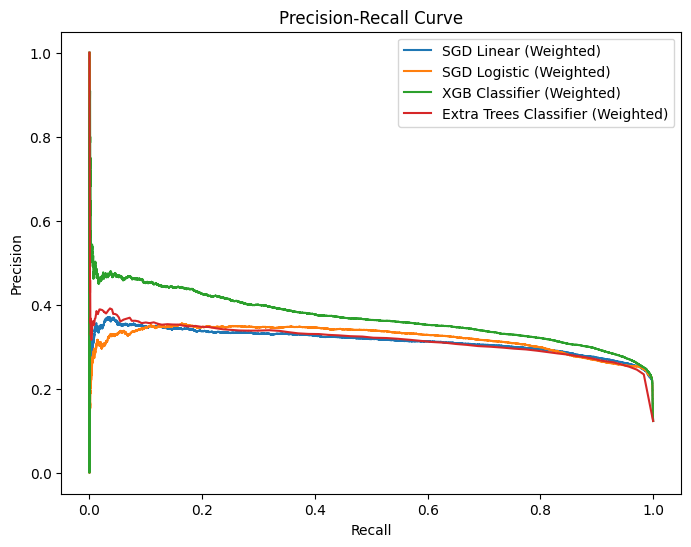

In [55]:
plt.figure(figsize=(8,6))

for name, model in models_weighted.items():
    y_scores = model.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 4.0 Balancing the dataset directly (Resampling)

In [6]:
smt = SMOTETomek(sampling_strategy=0.35, random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

In [45]:
res_df = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res, columns=['response']), left_index=True, right_index=True)
check_imbalance(res_df)

,no_count,yes_count,no_percentage,yes_percentage
0,260318,86430,75.074117,24.925883


In [52]:
sgd_lin_res = cross_validation_at_k(sgd_lin_cal, X_res, y_res, cv=5, k=20000)
sgd_log_res = cross_validation_at_k(sgd_log, X_res, y_res, cv=5, k=20000)
xgb_res = cross_validation_at_k(xgb_class, X_res, y_res, cv=5, k=20000)
extrees_res = cross_validation_at_k(extrees, X_res, y_res, cv=5, k=20000) 
knn_res = cross_validation_at_k(knn, X_res, y_res, cv=5, k=20000)

In [53]:
resampling_results = {'SGD Linear (Resampled)': sgd_lin_res,  
                      'SGD Logistic (Resampled)': sgd_log_res,
                      'XGB Classifier (Resampled)': xgb_res,
                      'Extra Trees Classifier (Resampled)': extrees_res,
                      'KNN (Resampled)': knn_res
}

cross_val_summary(resampling_results)

,Model Name,precision@k_mean,precision@k_std,recall@k_mean,recall@k_std,f1-score@k_mean,f1-score@k_std,fit_time_mean
3,Extra Trees Classifier (Resampled),0.74640,0.085095,0.86359,0.098455,0.80073,0.091289,8.60032
2,XGB Classifier (Resampled),0.70094,0.111324,0.81099,0.128803,0.75196,0.119428,0.71401
4,KNN (Resampled),0.62732,0.015696,0.72581,0.018161,0.67298,0.016839,-2.14278
0,SGD Linear (Resampled),0.54858,0.002232,0.63471,0.002582,0.58851,0.002394,3.16339
1,SGD Logistic (Resampled),0.54750,0.002942,0.63346,0.003404,0.58735,0.003156,0.53270


## Performance on test dataset + graphs:

In [54]:
# Extra Trees Classifier
extrees.fit(X_res, y_res)

# XGB Classifier
xgb_class.fit(X_res, y_res)

# KNN
knn.fit(X_res, y_res)

# SGD Linear
sgd_lin_cal.fit(X_res, y_res)

# SGD Logistic
sgd_log.fit(X_res, y_res)

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [55]:
rows = []
models = {
    'SGD Linear (Resampled)': sgd_lin_cal,
    'SGD Logistic (Resampled)': sgd_log,
    'XGB Classifier (Resampled)': xgb_class,
    'Extra Trees Classifier (Resampled)': extrees,
    'KNN (Resampled)': knn
}  

for name, m in models.items():
    y_hat = m.predict(X_test)
    y_hat_proba = m.predict_proba(X_test)[:,1]
    precision = precision_at_k(y_test, y_hat_proba, k=20000)
    recall = recall_at_k(y_test, y_hat_proba, k=20000)
    f1 = f_score_at_k(y_test, y_hat_proba, k=20000)
    bacc = balanced_accuracy_score(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat_proba)

    rows.append({
        'Model Name': name,
        'precision@k': precision,
        'recall@k': recall,
        'f1-score@k': f1,
        'balanced_accuracy': bacc,
        'roc_auc': roc_auc
    })

    test_results = pd.DataFrame(rows).sort_values(by='precision@k', ascending=False)

In [56]:
test_results

,Model Name,precision@k,recall@k,f1-score@k,balanced_accuracy,roc_auc
2,XGB Classifier (Resampled),0.3320,0.710769,0.452594,0.571190,0.853186
0,SGD Linear (Resampled),0.3185,0.681867,0.434190,0.682507,0.834783
1,SGD Logistic (Resampled),0.3182,0.681225,0.433781,0.680620,0.836854
3,Extra Trees Classifier (Resampled),0.3093,0.662171,0.421648,0.581927,0.831141
4,KNN (Resampled),0.2979,0.637765,0.406107,0.637748,0.804266


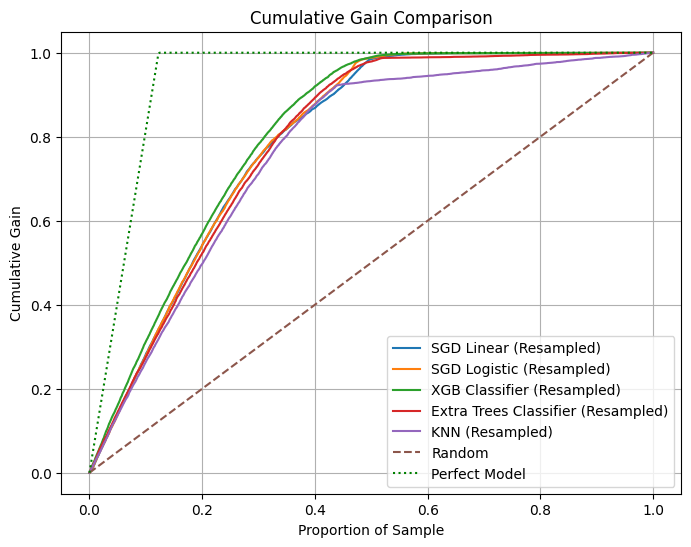

In [57]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_scores = model.predict_proba(X_test)[:,1]
    x, y = cumulative_gain(y_test.values, y_scores)
    plt.plot(x, y, label=name)

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("Proportion of Sample")
plt.ylabel("Cumulative Gain")

# proporção real de positivos
pi = y_test.mean()

# eixo x teórico
x_perfect = np.linspace(0, 1, 500)

# curva perfeita
y_perfect = np.where(x_perfect <= pi,
                     x_perfect / pi,
                     1)

plt.plot(x_perfect, y_perfect,
         linestyle=":",
         color="green",
         label="Perfect Model")

plt.legend()
plt.title("Cumulative Gain Comparison")
plt.grid(True)
plt.show()

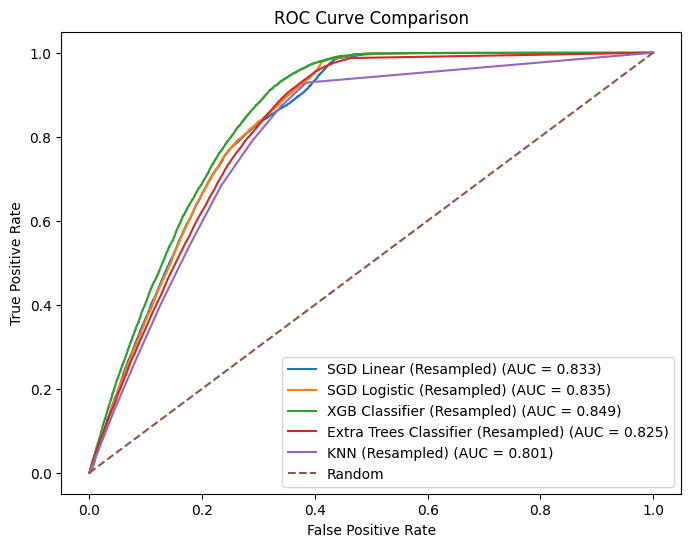

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_scores = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.grid(True)
plt.legend()
plt.show()

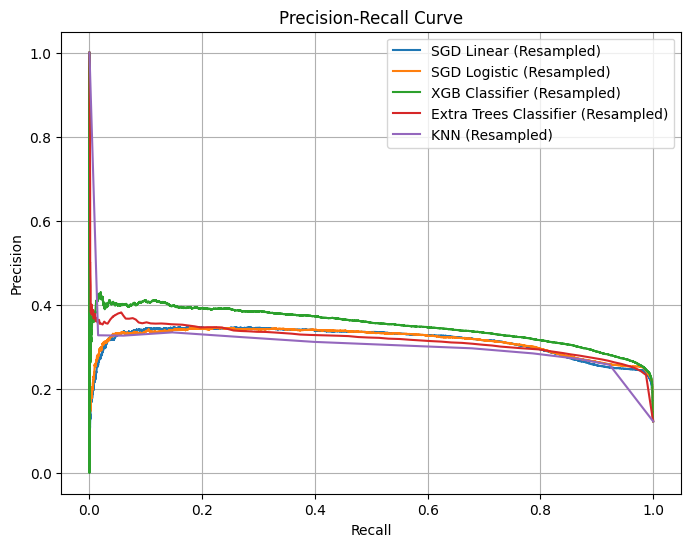

In [62]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_scores = model.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

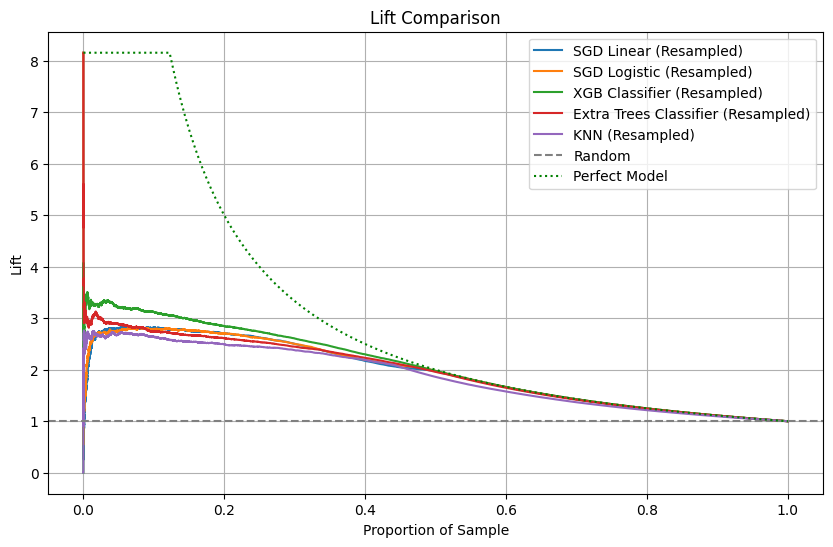

In [61]:
plt.figure(figsize=(10,6))

for name, model in models.items():
    y_scores = model.predict_proba(X_test)[:,1]
    x, lift = lift_curve(y_test.values, y_scores)
    plt.plot(x, lift, label=name)
    
plt.axhline(1, linestyle="--", color="gray", label="Random")
plt.xlabel("Proportion of Sample")
plt.ylabel("Lift")

# proporção real de positivos
pi = y_test.mean()

# eixo x teórico
x_perfect = np.linspace(0.0001, 1, 500)

lift_perfect = np.where(
    x_perfect <= pi,
    1/pi,
    1/x_perfect
)

plt.plot(x_perfect, lift_perfect,
         linestyle=":",
         color="green",
         label="Perfect Model")

plt.legend()
plt.title("Lift Comparison")
plt.grid(True)
plt.show()

---

---

# 5.0 Fine Tuning

In [9]:
precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=20000)

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_leaves': trial.suggest_int('max_leaves', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    model = xgb.XGBClassifier(**param, device='cuda')
    score = cross_val_score(model, X_res, y_res, cv=5, scoring=precision_at_k_scorer).mean()

    return score

In [ ]:
study = opt.create_study(study_name='xgb_optimization_cuda', direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

In [12]:
best_params = study.best_params
best_params

{'n_estimators': 654,
 'max_depth': 10,
 'learning_rate': 0.0928676578481242,
 'max_leaves': 100,
 'subsample': 0.6843881044357649,
 'colsample_bytree': 0.9698823594112738,
 'gamma': 0.979678428177832,
 'min_child_weight': 6.951405780464861}

In [13]:
best_score = study.best_value
best_score

0.7136899999999999

# 6.0 Final Model

In [21]:
params = {  'n_estimators': 654,
            'max_depth': 10,
            'learning_rate': 0.0928676578481242,
            'max_leaves': 100,
            'subsample': 0.6843881044357649,
            'colsample_bytree': 0.9698823594112738,
            'gamma': 0.979678428177832,
            'min_child_weight': 6.951405780464861}

xgb_final = xgb.XGBClassifier(**params)
joblib.dump(xgb_final, '../models/xgb_v01.joblib')

['../models/xgb_v01.joblib']

In [7]:
# Fit
xgb_final.fit(X_res, y_res)

# Predict
y_hat = xgb_final.predict(X_test)
y_hat_proba = xgb_final.predict_proba(X_test)[:,1]

# Performance metrics
precision = precision_at_k(y_test, y_hat_proba, k=20000)
recall = recall_at_k(y_test, y_hat_proba, k=20000)
f1 = f_score_at_k(y_test, y_hat_proba, k=20000)
bacc = balanced_accuracy_score(y_test, y_hat)
roc_auc = roc_auc_score(y_test, y_hat_proba)

rows = []
rows.append({
    'Model Name': 'XGB Classifier (Tuned)',
    'precision@k': precision,
    'recall@k': recall,
    'f1-score@k': f1,
    'balanced_accuracy': bacc,
    'roc_auc': roc_auc
})

final_results = pd.DataFrame(rows).sort_values(by='precision@k', ascending=False)
final_results

,Model Name,precision@k,recall@k,f1-score@k,balanced_accuracy,roc_auc
0,XGB Classifier (Tuned),0.32395,0.693535,0.44162,0.574673,0.847032


In [8]:
base_rate = y_test.mean()
model_score = final_results['precision@k'].iloc[0]

lift = model_score / base_rate  
print(f'Lift: {lift}')

Lift: 2.6431296189252835


In [9]:
y_true = np.array([y_test])       
y_score = np.array([y_hat_proba])

ndcg = ndcg_score(y_true, y_score, k=20000)
print(f"NDCG: {ndcg}")

NDCG: 0.6391795360665262


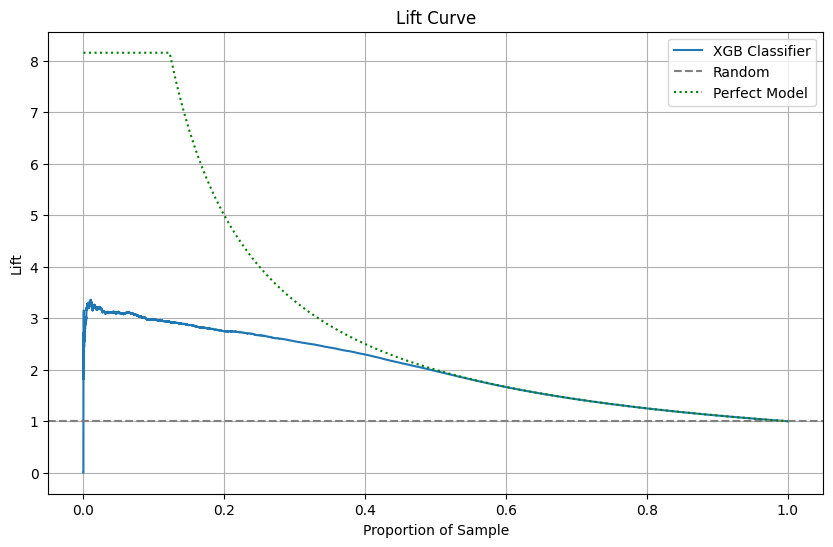

In [ ]:
plt.figure(figsize=(10,6))

x, lift = lift_curve(y_test.values, y_hat_proba)

plt.plot(x, lift, label="XGB Classifier")

# baseline (random model)
plt.axhline(1, linestyle="--", color="gray", label="Random")

plt.xlabel("Proportion of Sample")
plt.ylabel("Lift")
plt.title("Lift Curve")

pi = y_test.mean()

x_perfect = np.linspace(0.0001, 1, 500)

lift_perfect = np.where(
    x_perfect <= pi,
    1/pi,
    1/x_perfect
)

plt.plot(x_perfect, lift_perfect,
         linestyle=":",
         color="green",
         label="Perfect Model")

plt.legend()
plt.grid(True)
plt.show()

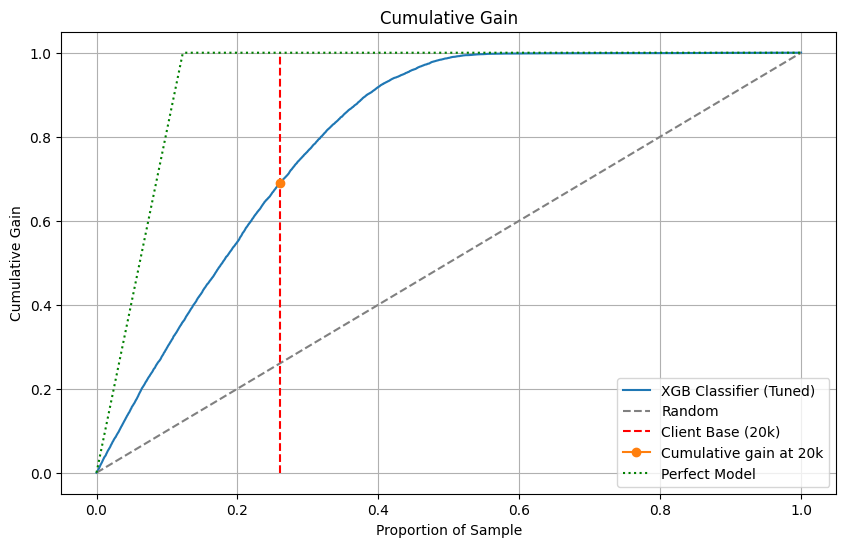

In [27]:
plt.figure(figsize=(10,6))

x, y = cumulative_gain(y_test.values, y_hat_proba)
plt.plot(x, y, label='XGB Classifier (Tuned)')

plt.plot([0,1], [0,1], linestyle="--", label="Random", color='gray')
plt.plot([0.26, 0.26], [0,1], linestyle="--", label="Client Base (20k)", color='red')
plt.plot(0.26, 0.69, marker='o', markersize=6, label="Cumulative gain at 20k")

plt.xlabel("Proportion of Sample")
plt.ylabel("Cumulative Gain")

# proporção real de positivos
pi = y_test.mean()

# eixo x teórico
x_perfect = np.linspace(0, 1, 500)

# curva perfeita
y_perfect = np.where(x_perfect <= pi,
                     x_perfect / pi,
                     1)

plt.plot(x_perfect, y_perfect,
         linestyle=":",
         color="green",
         label="Perfect Model")

plt.legend()
plt.title("Cumulative Gain")
plt.grid(True)
plt.show()

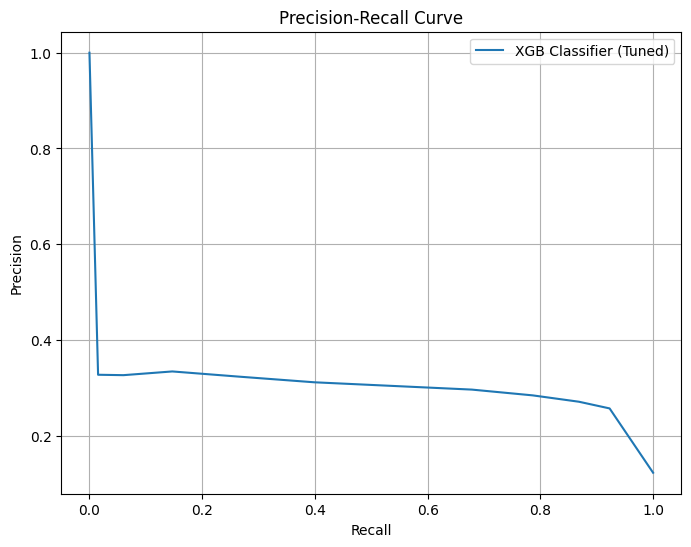

In [63]:
plt.figure(figsize=(8,6))

precision, recall, _ = precision_recall_curve(y_test, y_hat_proba)
plt.plot(recall, precision, label='XGB Classifier (Tuned)')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()